# TBATS (<u>T</u>rigonometric <u>B</u>ox-cox transformation, <u>A</u>RMA errors, <u>T</u>rend and <u>S</u>easonal components)

## TBATS model takes it roots in exponential smoothing methods and can be described by the following equations:

<a><img src= "https://miro.medium.com/max/3000/1*yfruZnSYsNt1X1uyag46eQ.png" width="600"> </a>

Each seasonality is modeled by a trigonometric representation based on Fourier series. One major advantage of this approach is that it requires only 2 seed states regardless of the length of period. 

## How Does TBATS Choose The Final Model?
Under the hood TBATS will consider various alternatives and fit quite a few models. It will consider models:
* with Box-Cox transformation and without it.
* with and without Trend
* with and without Trend Damping
* with and without ARMA(p,q) process used to model residuals
* non-seasonal model
* various amounts of harmonics used to model seasonal effects

<p> The final model will be chosen using <u>Akaike information criterion (AIC).</u></p>
In particular auto ARMA is used to decide if residuals need modeling and what p and q values are suitable.

## Implementation of TBATS
 Data consists of 50 store datasets, and 50 items. We will only <u> select Item 1 at Store 1 </u>

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tbats import TBATS, BATS
import numpy as np

df = pd.read_csv('../input/demand_store_forecast/train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
df = df.set_index('date')
y = df['sales']
y_to_train = y.iloc[:(len(y)-365)]
y_to_test = y.iloc[(len(y)-365):] # last year for testing

In [2]:
plot_df = pd.DataFrame(y_to_train)
plot_df['date'] = plot_df.index
# dataframe of a long format
plot_df = pd.melt(plot_df, id_vars='date', value_vars=plot_df.columns[:-1])

In [3]:
# Plot the sales of item for Item 1 Store 1
fig = px.line(plot_df , x ='date', y = 'value', title='Daily sales for Item 1 at Store 1')
fig.update_layout(width=800, height=340)
fig.show()

# TBATS Model

In [4]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit  (y_to_train)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [31]:
import numpy as np
v = pd.Series(y_forecast, index = pd.Index(y_to_test.index, name = 'date'))


You may have noticed that yearly season length is not an integer. It equals 365.25 to account for leap years, a feature TBATS is able to handle. 
<p> TBATS seems to have done a pretty good job in modeling both of seasonal effects:

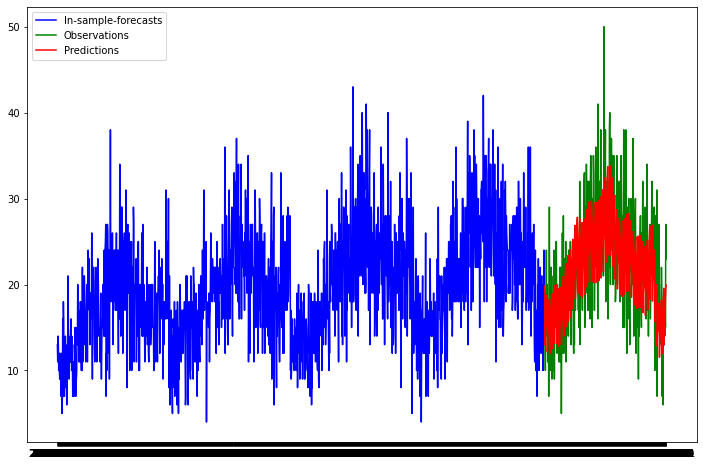

In [44]:
plt.figure(figsize=(12,8))
plt.plot(y_to_train, color = 'blue', label = 'In-sample-forecasts')
plt.plot(y_to_test, color = 'green', label = 'Observations')
plt.plot(v, color='red',label="Predictions")
plt.legend(loc="upper left")

In [40]:
four_weeks = y_to_test.loc['2017-12-10':'2017-12-31']
four_weeks_pred = v.loc['2017-12-10':'2017-12-31']

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

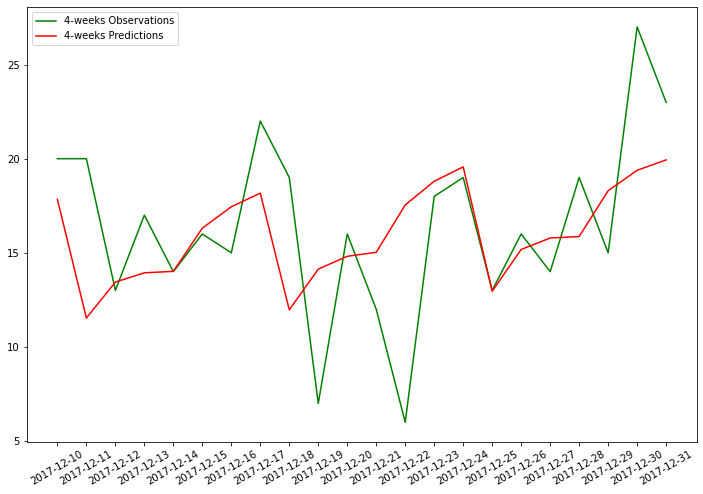

In [48]:
plt.figure(figsize=(12,8))
plt.plot(four_weeks, color = 'green', label = '4-weeks Observations')
plt.plot(four_weeks_pred, color='red',label="4-weeks Predictions")
plt.legend(loc="upper left")
plt.xticks(rotation = 30)

## SARIMA Model With Weekly Seasonality

SARIMA has proven to provide state of the art solutions to time series forecasting. Unfortunately it has two major drawbacks: <p>(1) one can model only a single seasonal effect,</p> <p>(2) season length should not be too long.

---------------------------------------------
We shall ignore yearly seasonality and <u>focus on modeling weekly seasonal</u> pattern

In [49]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=7)
y_arima_forecast = arima_model.predict(n_periods=365)

In [64]:
y_arima_forecast = y_arima_forecast.round(2)
arima_model

ARIMA(order=(4, 1, 4), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

Auto arima has chosen SARIMA(4, 1, 4)x(0, 0, 2, 7) model. As expected yearly pattern is not modeled. 

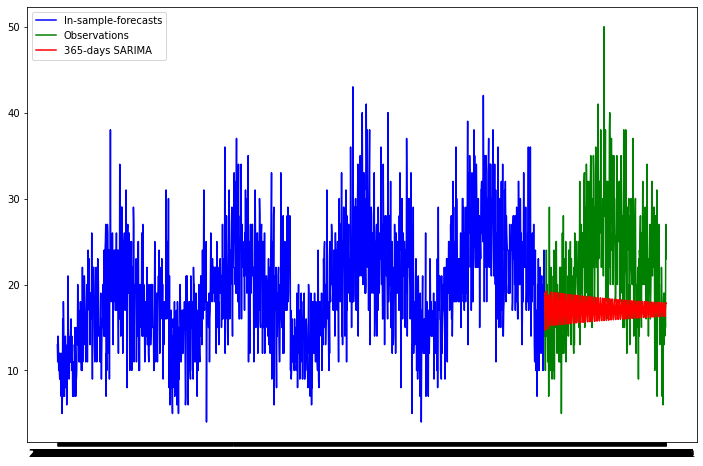

In [85]:
sarima = pd.Series(y_arima_forecast, index = pd.Index(y_to_test.index, name = 'date'))
plt.figure(figsize=(12,8))
plt.plot(y_to_train, color = 'blue', label = 'In-sample-forecasts')
plt.plot(y_to_test, color = 'green', label = 'Observations')
plt.plot(sarima, color='red',label="365-days SARIMA")
plt.legend(loc="upper left")

## SARIMAX with Fourier Terms

We will keep modeling the weekly pattern with seasonal part of SARIMA. For the yearly seasonal pattern we will use the above-mentioned trick
**********************************
I have compared multiple choices for the number of Fourier terms and 2 provides the most accurate forecasts. Therefore we shall use 2 Fourier terms as exogenous variables.

In [92]:
# prepare Fourier terms
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(y)-365)]
exog_to_test = exog.iloc[(len(y)-365):]
# Fit model
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)

In [93]:
y_arima_exog_forecast = y_arima_exog_forecast.round(2) # round to 2 decimal places
y_SARIMAX_Fourier = pd.Series(y_arima_exog_forecast, index = pd.Index(y_to_test.index, name = 'date')) # convert into pd Series.

## Visualise SARIMAX with 2 fourier terms
# plt.figure(figsize=(12,8))
# plt.plot(y_to_train, color = 'blue', label = 'In-sample-forecasts')
# plt.plot(y_to_test, color = 'green', label = 'Observations')
# plt.plot(y_SARIMAX_Fourier, color='red',label="365-days SARIMAX-fourier")
# plt.legend(loc="upper left")

## Evaluation

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_to_test = y_to_test.sort_index(axis = 0)
sarima = sarima.sort_index(axis = 0)
v = v.sort_index(axis = 0)
y_SARIMAX_Fourier = y_SARIMAX_Fourier.sort_index(axis = 0)

####### MAE ######
print("Mean absolute error SARIMA: %.2f" %mean_absolute_error(y_to_test.values, sarima.values))
print("Mean absolute error TBATS: %.2f" %mean_absolute_error(y_to_test.values, v.values))
print("Mean absolute error SARIMAX with 2 Fourier Terms: %.2f" %mean_absolute_error(y_to_test.values, y_SARIMAX_Fourier.values))
print ("\n")
####### MSE ######
print("Mean squared error SARIMA: %.2f" %mean_squared_error(y_to_test.values, sarima.values))
print("Mean squared error TBATS: %.2f" %mean_squared_error(y_to_test.values, v.values))
print("Mean squared error SARIMAX with 2 Fourier Terms: %.2f" %mean_squared_error(y_to_test.values, y_SARIMAX_Fourier.values))



Mean absolute error SARIMA: 6.66
Mean absolute error TBATS: 3.86
Mean absolute error SARIMAX with 2 Fourier Terms: 4.74


Mean squared error SARIMA: 71.04
Mean squared error TBATS: 23.64
Mean squared error SARIMAX with 2 Fourier Terms: 34.98
